Mesh Parameterization
=====================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores 2-D parameterization of 3D surfaces using linear methods.


A  review paper for mesh parameterization can be found in:


M.S. Floater and K. Hormann,
_Surface Parameterization: a Tutorial and Survey_
in Advances in multiresolution for geometric modelling, p. 157-186, 2005.


See also:


K. Hormann,  K. Polthier and A. Sheffer
_Mesh parameterization: theory and practice,_
Siggraph Asia Course Notes

In [1]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"

library(Matrix)
library(rgl)
library(geometry)
library(plotly)
library(akima)
library(plot3D)
library(network)

# Importing the libraries
for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}
for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

Loading required package: magic
Loading required package: abind
Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘pracma’

The following objects are masked _by_ ‘.GlobalEnv’:

    circshift, fftshift, grad, ifftshift

The following objects are masked f

Conformal Laplacian
-------------------
The conformal Laplacian uses the cotan weights to obtain an accurate
discretization of the Laplace Beltrami Laplacian.


They where first introduces as a linear finite element approximation of the
Laplace-Beltrami operator in:


U. Pinkall and K. Polthier,
_Computing discrete minimal surfaces and their conjugates_
Experimental Mathematics, 2(1):15-36, 1993.


First load a mesh. The faces are stored in a matrix $F = (f_j)_{j=1}^m \in \RR^{3 \times m}$
of $m$ faces $f_j \in \{1,\ldots,n\}^3$. The position of the vertices are
stored in a matrix $X  = (x_i)_{i=1}^n \in \RR^{3 \times n}$ of $n$ triplets of points
$x_k \in \RR^3$

In [2]:
X = read_mesh("nt_toolbox/data/nefertiti.off")$X0
F = read_mesh("nt_toolbox/data/nefertiti.off")$F0
n = dim(X)[2]

In order to perform mesh parameterization, it is important that this mesh
has the topology of a disk, i.e. it should have a single B.


First we compute the boundary $B = (i_1,\ldots,i_p)$ of the mesh.
By definition, for the edges $(i_k,i_{k+1})$, there is a single adjacent face $
(i_k,i_{k+1},\ell) $.

In [3]:
B = compute_boundary(F)

Length of the boundary.

In [4]:
p = length(B)

Display the boundary.

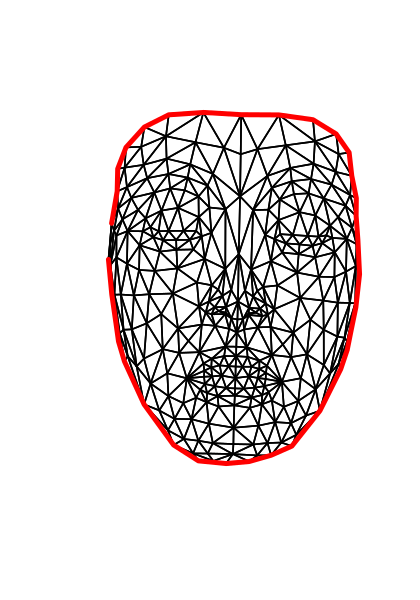

In [6]:
options(repr.plot.width=3.5, repr.plot.height=5)
# plot mesh
plot_mesh(X,F)

#plot boundary
lines(X[1,B+1], X[2,B+1], col="red", lwd=3)

The conformal Laplacian weight matrix $W \in \RR^{n \times n}$ is
defined as
$$ W_{i,j} =
      \choice{
          \text{cotan}(\al_{i,j}) + \text{cotan}(\be_{i,j})
          \qifq i \sim j \\
          \quad 0 \quad \text{otherwise}.
      }
$$
Here, $i \times j$ means that there exists two faces
$ (i,j,k) $ and $ (i,j,\ell) $ in the mesh (note that for B
faces, one has $k=\ell$).


The angles are the angles centered as $k$ and $\ell$, i.e.
$$ \al_{i,j} = \widehat{x_i x_k x_j }
  \qandq
  \be_{i,j} = \widehat{x_i x_\ell x_j }. $$


Compute the conformal 'cotan' weights.
Note that each angle $\alpha$ in the mesh contributes with
$1/\text{tan}(\alpha)$ to the weight of the opposite edge.
We compute $\alpha$ as
$$ \alpha = \text{acos}\pa{ \frac{\dotp{u}{v}}{\norm{u}\norm{v}} } $$
where $u \in \RR^3, v \in \RR^3$ are the edges of the adjacent vertices
that defines $\al$.

In [6]:
W = Matrix(0, nrow=n, ncol=n, sparse=TRUE)

for (i in (0:2))
{
  i2 = (i+1)%%3
  i3 = (i+2)%%3
  u = X[,(F+1)[i2+1,]] - X[,(F+1)[i+1,]]
  v = X[,(F+1)[i3+1,]] - X[,(F+1)[i+1,]]
  u = u/rbind(sqrt(colSums(u**2)), sqrt(colSums(u**2)),sqrt(colSums(u**2)));
  v = v/rbind(sqrt(colSums(v**2)), sqrt(colSums(v**2)),sqrt(colSums(v**2)));
  alpha = 1/(tan(acos(colSums(u*v))))
  alpha = pmax(alpha, 10^(-2)*matrix(1,nrow=1, ncol=length(alpha)))
  W = W+sparseMatrix(x=alpha, i=(F+1)[i2+1,], j=(F+1)[i3+1,], dims=c(n,n))
  W = W+sparseMatrix(x=alpha, i=(F+1)[i3+1,], j=(F+1)[i2+1,], dims=c(n,n))
}

Compute the symmetric Laplacian matrix
$L = D-W$ where $D = \mathrm{Diag}_i\pa{\sum_j W_{i,j}}$

In [7]:
d = as.vector(colSums(W))
D = Diagonal(length(d),d)
L = D - W 

Fixed Boundary Harmonic Parameterization
----------------------------------------
The problem of mesh parameterization corresponds to finding
2-D locations $(y_i = (y_i^1,y_i^2) \in \RR^2$
for each original vertex, where $ Y = (y_i)_{i=1}^n \in \RR^{2 \times n} $
denotes the flattened positions.


The goal is for this parameterization to be valid, i.e. the 2-D
mesh obtained by replacing $X$ by $Y$ but keeping the same face connectivity $F$
should not contained flipped faces (all face should have the same orientation in the plane).



We consider here a linear methods, that finds the parameterization, that
impose that the coordinates are harmonic inside the domain, and have
fixed position on the boundary (Dirichlet conditions)
$$ \forall s=1,2, \quad \forall i \notin B, \quad (L y^s)_i = 0,
\qandq \forall j \in B, \quad y^s_j = z_j^s. $$


In order for this method to define a valid parameterization, it is
necessary that the fixed position $ z_j = (z^1_j,z^2_j) \in \RR^2 $
are consecutive points along a convex polygon.


Compute the fixed positions $Z=(z_j)_j$ for the vertices on $B$.
Here we use a circle.

In [8]:
p = length(B)
t = seq(from=0,to=2*pi,by=(2*pi/p))
t = t[-(p+1)]
Z = rbind(cos(t),sin(t))

Computing the parameterization requires to solve two independent linear
system
$$ \forall s=1,2, \quad  L_1 y^s = r^s $$
where $L_1$ is a modified Laplacian, the is obtained from $L$ by
$$ \choice{
      \forall i \notin B, \quad (L_0)_{i,j} = L_{i,j} \\
      \forall i \in B, \quad (L_0)_{i,i}=1, \\
      \forall i \in B, \forall j \neq i, \quad (L_0)_{i,i}=0,
  } $$
i.e. replacing each row indexed by $B$ by a 1 on the diagonal.

In [9]:
L1 = Matrix(L, sparse=TRUE)

L1[B+1,] = 0

for (i in (1:length(B)))
{
   L1[(B + 1)[i], (B + 1)[i]] = 1
}

Set up the right hand size $R$ with the fixed position.

In [10]:
R = Matrix(0, nrow=2, ncol=n)
R[,B+1] = Z

Solve the two linear systems.

In [11]:
Y = Matrix(0, nrow=2, ncol=n)

Y[1,] = solve(L1,R[1,])
Y[2,] = solve(L1,R[2,])

Display the parameterization.

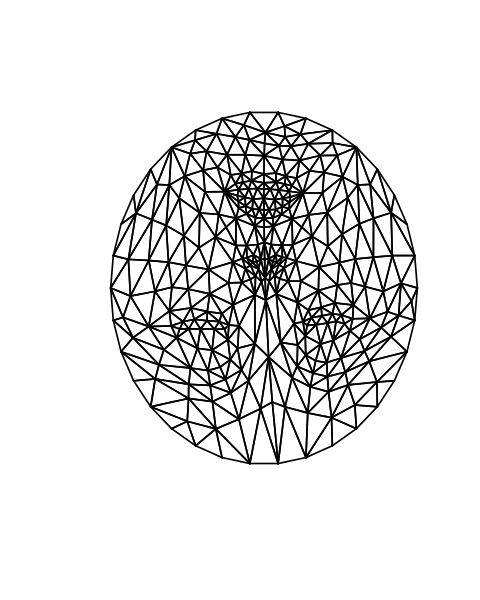

In [12]:
options(repr.plot.width=4, repr.plot.height=5, colorscale=gray)

plot_mesh(as.matrix(rbind(Y,matrix(0,nrow=1,ncol=n))),F)


Mesh Parameterization on a Square
---------------------------------
One can perform a fixed B parameterization on a square.
This is useful to compute a geometry image (a color image storring the
position of the vertices).

__Exercise 1__

Compute the fixed positions $Z$ of the points indexed by $B$ that are along a
square. Warning: $p$ is not divisible by 4.

In [13]:
## Insert your code here.

__Exercise 2__

Compute the parameterization $Y$ on a square.

In [14]:
## Insert your code here.

__Exercise 3__

Shift the $B$ positions so that the eyes of the model are approximately
horizontal.

In [15]:
## Insert your code here.

Re-align the Texture
--------------------
To map correctly a real image on the surface, the texture needs to be aligned.
We use here a simple affine mapping to map the eye and mouth of the image
on the corresponding location on the surface.


Load a texture image $T$.

In [16]:
library(Matrix)
C  =  replicate(3, runif(1000, 0, 1)) 
C  =  C/cbind(Matrix(rowSums(C)),Matrix(rowSums(C)),Matrix(rowSums(C))) 
C  =  C[order(C[,1], C[,2], C[,3]),]
lambd = t(C)

In [17]:
library(imager)
library(magick)

n1  =  256
T  =  load_image("nt_toolbox/data/lena.png", n1)

Loading required package: plyr

Attaching package: 'plyr'

The following object is masked from 'package:network':

    is.discrete

The following objects are masked from 'package:plotly':

    arrange, mutate, rename, summarise

Loading required package: magrittr

Attaching package: 'magrittr'

The following objects are masked from 'package:pracma':

    and, mod, or


Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:tuneR':

    channel, play

The following object is masked from 'package:akima':

    interp

The following object is masked from 'package:plotly':

    highlight

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image

Linking to ImageMagick 6.9.6.6
Enabled fe

Display the texture on the mesh, using the parametrization of the mesh as
texture coordinates.

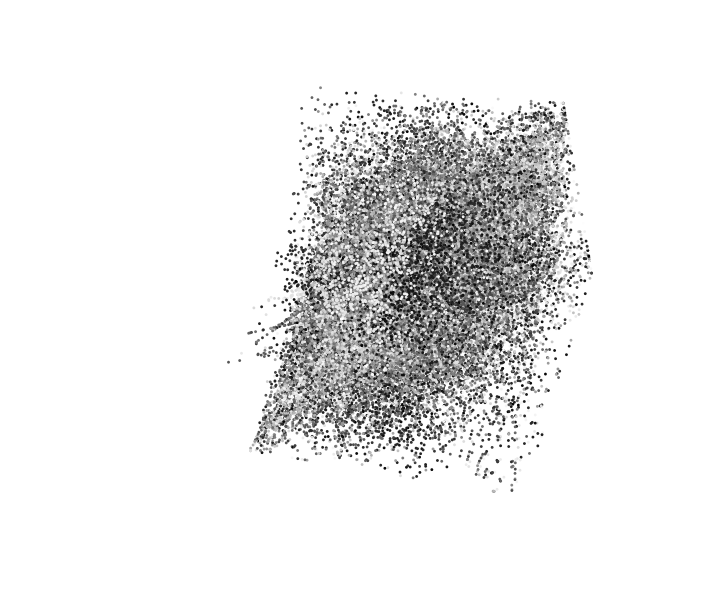

In [18]:
options(repr.plot.width=6, repr.plot.height=5)

x  =  seq(from = 0, to = 1, by = 1/(dim(T)[1]-1))

for (i in (1:100)){
    
    px  =  Y[1,(F+1)[,i]]
    py  =  Y[2, (F+1)[,i]]
        
    points_x  =  t(lambd) %*% px
    points_y  =  t(lambd) %*% py
    points  =  cbind(points_x,points_y)
    
    col  =  rescale(bicubic(x, x, T, points_x, points_y )$z)
    col1  =  cbind(col, col, col)
                   
    Px = X[1,(F+1)[,i]]
    Py = X[2,(F+1)[,i]]
    Pz = X[3,(F+1)[,i]]
    
    Points_x  =  t(lambd) %*% Px
    Points_y  =  t(lambd) %*% Py
    Points_z  =  t(lambd) %*% Pz
    
    points3D(matrix(Points_x), matrix(Points_y), matrix(Points_z), col=as.color(col), pch=20, box=FALSE,colkey=FALSE,cex=0.05, theta=10)
    par(new=TRUE)
}


Position $(u_1,u_2,u_3)$ of the eyes and the mouth in the texture.

In [19]:
u1  =  c(267,266)*n1/512
u2  =  c(267,328)*n1/512
u3  =  c(355,301)*n1/512

Display.

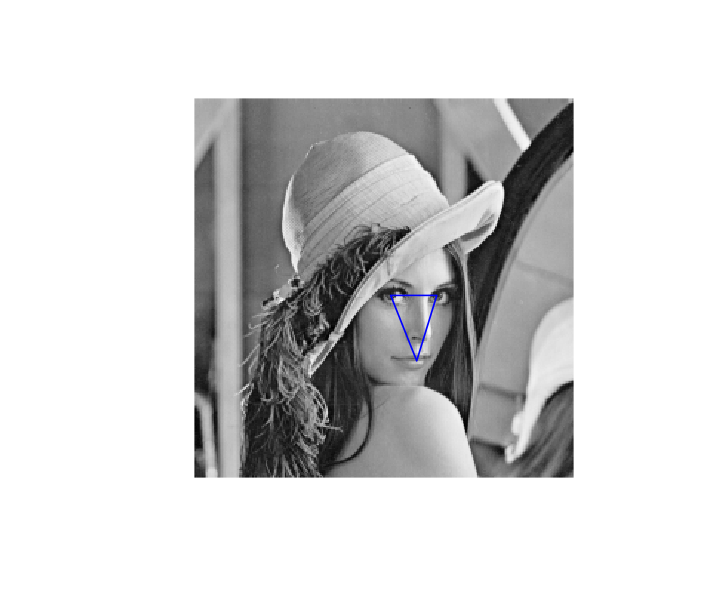

In [26]:
imageplot(T)
lines(c(u1[2],u2[2],u3[2], u1[2]),c(u1[1],u2[1],u3[1],u1[1]), col="blue")

Positions $(v_1,v_2,v_3)$ of the eyes and the mouth on the parameteric domain

In [27]:
v1  =  c(310,125)*n1/512.
v2  =  c(315,350)*n1/512.
v3  =  c(105,232)*n1/512.

Display.

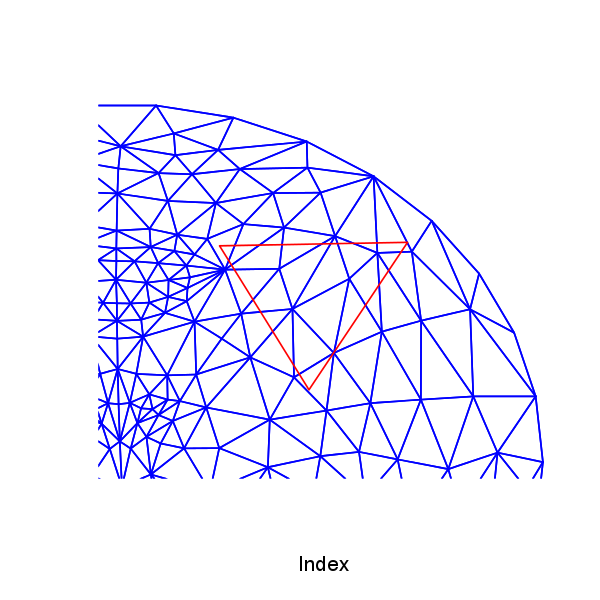

In [28]:
options(repr.plot.width=5, repr.plot.height=5)

Y_big  =  Y*(n1-1) + 1
beg  =  sort(W@i)
end  =  W@i

plot (NA, xlim=c(0,250), ylim=c(0,250), box=FALSE, clab="", ylab="", axes=FALSE)
for (i in (1:length(beg))){
    lines(c(Y_big[1, (beg+1)[i]],Y_big[1,(end+1)[i]]), c(Y_big[2,(beg+1)[i]], Y_big[2,(end+1)[i]]), col="Blue", xlab="", ylab="", axes=FALSE)
}

lines (c(v1[2],v2[2],v3[2], v1[2]),c(v1[1],v2[1],v3[1],v1[1]), col="red")

Apply a similitude to the image so that the mouth and the eye have the correct position in parametric domain.

In [29]:
T1  =  t(perform_image_similitude(T, "affine", (u1-1)/n1,(v1-1)/n1,(u2-1)/n1,(v2-1)/n1,(u3-1)/n1,(v3-1)/n1))

Display the mesh with the image overlaid.

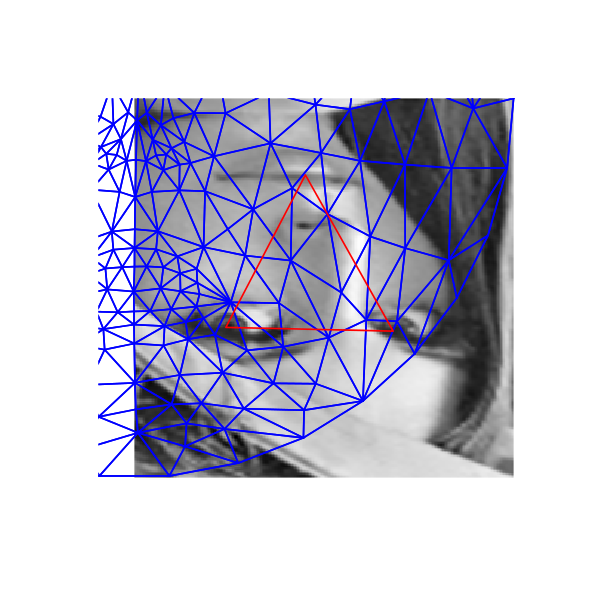

In [30]:
imageplot(T1)
for (i in (1:length(beg))){
    lines(c(Y_big[1, (beg+1)[i]],Y_big[1,(end+1)[i]]), c(Y_big[2,(beg+1)[i]], Y_big[2,(end+1)[i]]), col="Blue", xlab="", ylab="", axes=FALSE)
}

lines (c(v1[2],v2[2],v3[2], v1[2]),c(v1[1],v2[1],v3[1],v1[1]), col="red")

Display the texture mapped mesh.

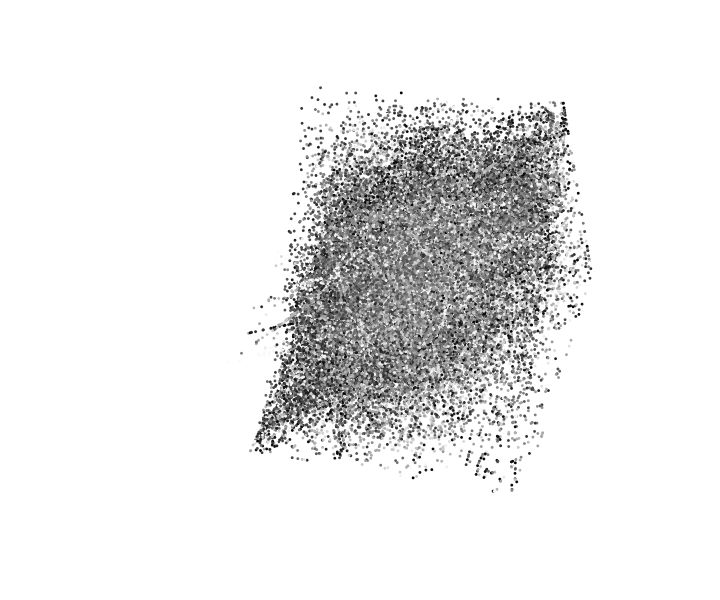

In [31]:
options(repr.plot.width=6, repr.plot.height=5)

x  =  seq(from = 0, to = 1, by = 1/(dim(T)[1]-1))

for (i in (1:100)){
    
    px  =  Y[1,(F+1)[,i]]
    py  =  Y[2, (F+1)[,i]]
        
    points_x  =  t(lambd) %*% px
    points_y  =  t(lambd) %*% py
    points  =  cbind(points_x,points_y)
    
    col  =  rescale(bicubic(x, x, T1, points_x, points_y )$z)
    col1  =  cbind(col, col, col)
                   
    Px = X[1,(F+1)[,i]]
    Py = X[2,(F+1)[,i]]
    Pz = X[3,(F+1)[,i]]
    
    Points_x  =  t(lambd) %*% Px
    Points_y  =  t(lambd) %*% Py
    Points_z  =  t(lambd) %*% Pz
    
    points3D(matrix(Points_x), matrix(Points_y), matrix(Points_z), col=as.color(col), pch=20, box=FALSE,colkey=FALSE,cex=0.05, theta=10)
    par(new=TRUE)
}